# DiploDatos Kaggle Competition

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

## Exploración de datos - Todos los miembros del grupo

### Train

Cargamos los datos de entrenamiento que vamos a utilizar para generar nuestro modelo.

In [ ]:
train_df = pd.read_csv('diabetes_prediction_dataset_train-labeled.csv')
print(train_df.shape)
print(train_df.describe())

(95000, 10)
             patient           age  hypertension  heart_disease           bmi  \
count   95000.000000  95000.000000  95000.000000   95000.000000  95000.000000   
mean    50016.501389     41.935269      0.075074       0.039463     27.320879   
std     28868.357071     22.514788      0.263512       0.194695      6.626335   
min         1.000000      0.080000      0.000000       0.000000     10.010000   
25%     25021.750000     24.000000      0.000000       0.000000     23.650000   
50%     50024.000000     43.000000      0.000000       0.000000     27.320000   
75%     75024.250000     60.000000      0.000000       0.000000     29.580000   
max    100000.000000     80.000000      1.000000       1.000000     95.690000   

        HbA1c_level  blood_glucose_level      diabetes  
count  95000.000000         95000.000000  95000.000000  
mean       5.527659           138.070537      0.085074  
std        1.070261            40.739962      0.278993  
min        3.500000           

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


In [ ]:
# get the number cases per gender and their percentage
gender_counts = train_df['gender'].value_counts()
gender_percentage = gender_counts / len(train_df) * 100

gender_counts, gender_percentage

(gender
 Female    55563
 Male      39421
 Other        16
 Name: count, dtype: int64,
 gender
 Female    58.487368
 Male      41.495789
 Other      0.016842
 Name: count, dtype: float64)

In [ ]:
# get the number cases per smoking_history and their percentage
smoking_counts = train_df['smoking_history'].value_counts()
smoking_percentage = smoking_counts / len(train_df) * 100

smoking_counts, smoking_percentage



(smoking_history
 No Info        33958
 never          33389
 former          8911
 current         8821
 not current     6129
 ever            3792
 Name: count, dtype: int64,
 smoking_history
 No Info        35.745263
 never          35.146316
 former          9.380000
 current         9.285263
 not current     6.451579
 ever            3.991579
 Name: count, dtype: float64)

In [ ]:

# current: sería actual (que fuma actualmente) supongo riesgo alto.
# former : fumador anterior.. algo de riesgo.
# ever: alguna vez fumó.. bajo riesgo.
# never: nunca fumó.. mas bajo riesgo
# No-info: no se sabe.. (edited


if train_df['smoking_history'].dtype == 'object':
    smoking_history_dict = {'No Info': 0, 'never': 1, 'ever': 2, 'former': 3, 'not current': 4, 'current': 5 }
    train_df['smoking_history'] = train_df['smoking_history'].map(smoking_history_dict)

# Transform column Gender to numerical using this dictionary
if train_df['gender'].dtype == 'object':
    gender_dict = {'Male': 0, 'Female': 1, 'Other': 2}
    train_df['gender'] = train_df['gender'].map(gender_dict)


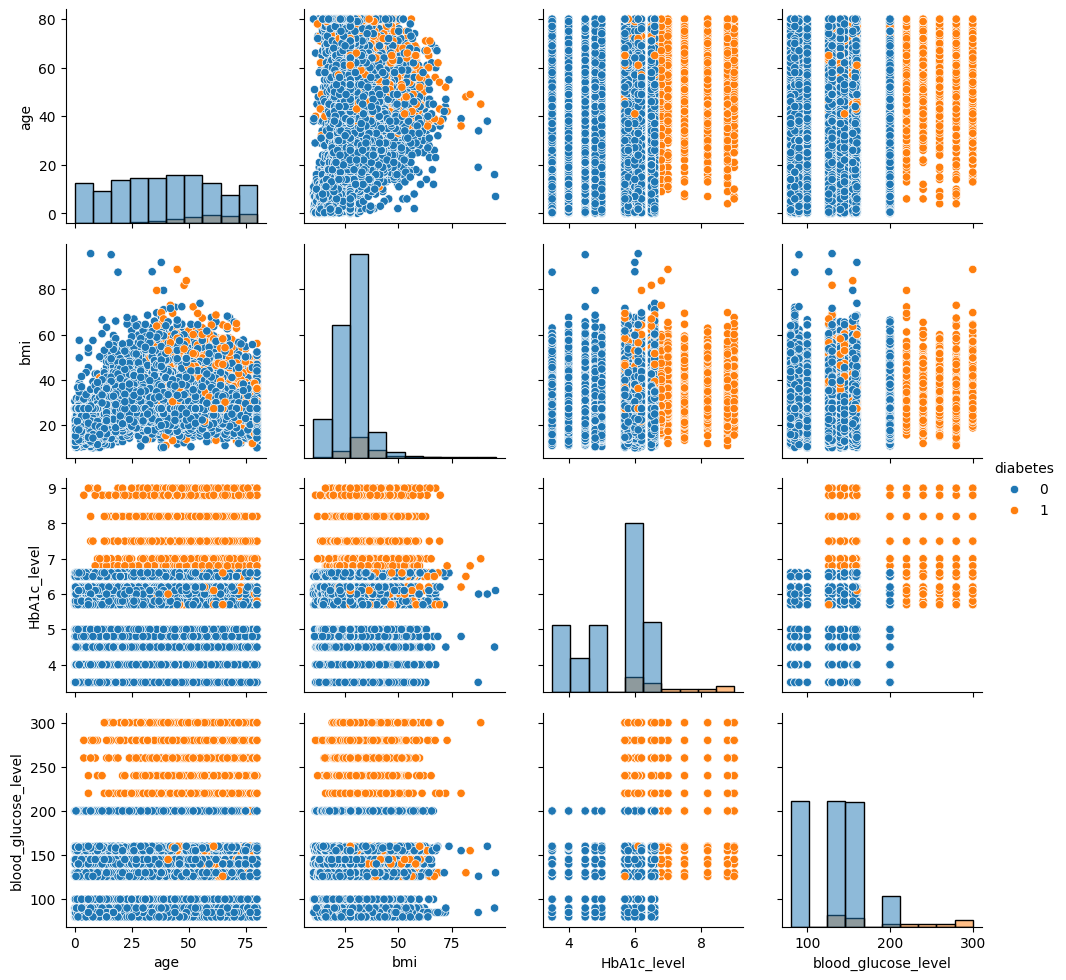

In [ ]:
df_cont = train_df.loc[:,["age",'bmi', 'HbA1c_level', 'blood_glucose_level','diabetes']]

g = sns.PairGrid(df_cont, hue = 'diabetes')
g.map_diag(sns.histplot, bins = 10)
g.map_offdiag(sns.scatterplot)
g.add_legend()


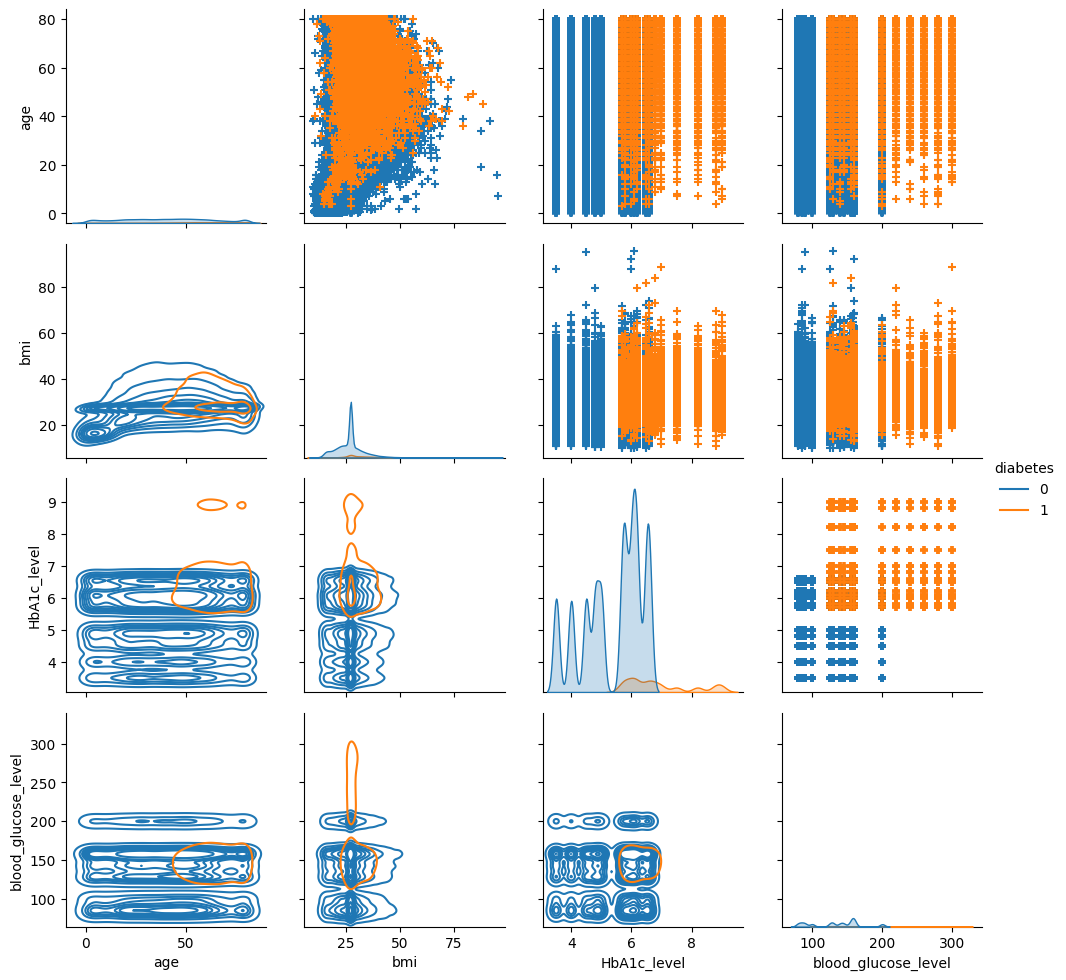

In [ ]:
cols = [ "age", "bmi", "HbA1c_level", "blood_glucose_level", "diabetes"]
# cols = ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level", "diabetes"]

g = sns.PairGrid(train_df[cols], hue='diabetes')
g = g.map_upper(plt.scatter, marker='+')
g = g.map_lower(sns.kdeplot)
# g.map_diag(sns.histplot, bins = 10)
g = g.map_diag(sns.kdeplot, fill=True)

# Add legend
g.add_legend()

# Show plot
plt.show()

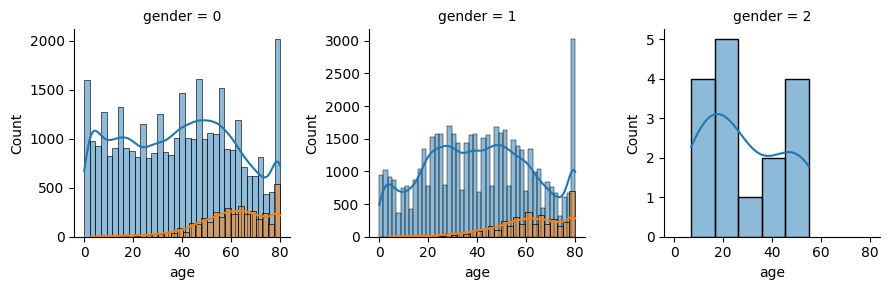

<Axes: xlabel='smoking_history', ylabel='age'>

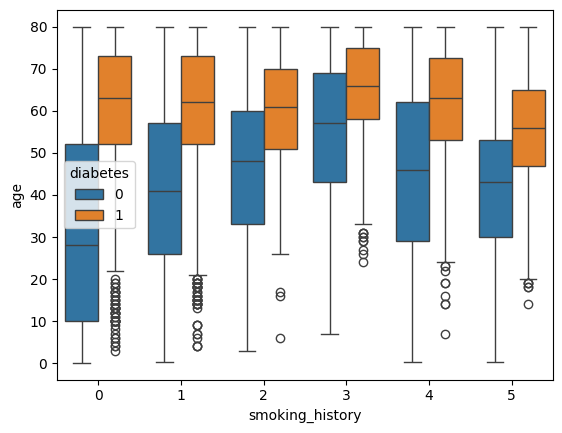

In [ ]:
g = sns.FacetGrid(train_df, col = 'gender', hue = 'diabetes',  sharey=False)
g.map(sns.histplot,'age', kde = True) ### no parece haber un efecto marcado del sexo
plt.show()
sns.boxplot(train_df, x = 'smoking_history', y = 'age',hue = 'diabetes')

In [ ]:
# percentage of diabetes in the dataset
diabetes_percentage = train_df['diabetes'].value_counts(normalize=True) * 100
print(diabetes_percentage)

# percentage of rows by gender and find the percentage of diabetes in each
gender_percentage = train_df['gender'].value_counts(normalize=True) * 100
diabetes_percentage_by_gender = train_df.groupby('gender')['diabetes'].mean() * 100

print(diabetes_percentage_by_gender)


diabetes
0    91.492632
1     8.507368
Name: proportion, dtype: float64
gender
0    9.763831
1    7.618379
2    0.000000
Name: diabetes, dtype: float64


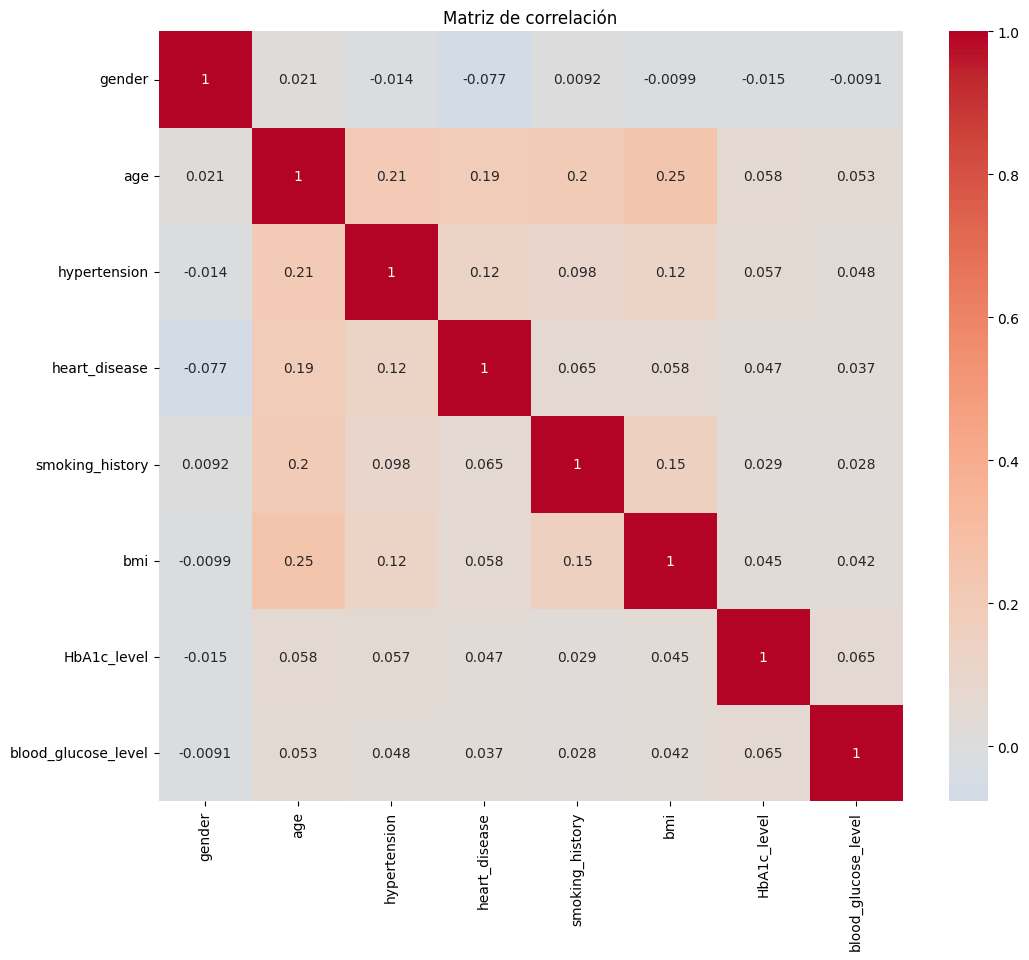

In [ ]:
# Draw a chart with correlation between each column and the diabetes column, except the patient column
cols = ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]

corr = train_df[cols].corr(method='kendall')
# corr = train_df[cols].corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot_kws={"size": 10}, annot=True)
plt.title('Matriz de correlación')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')  # Save the plot to a file
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Empty DataFrame


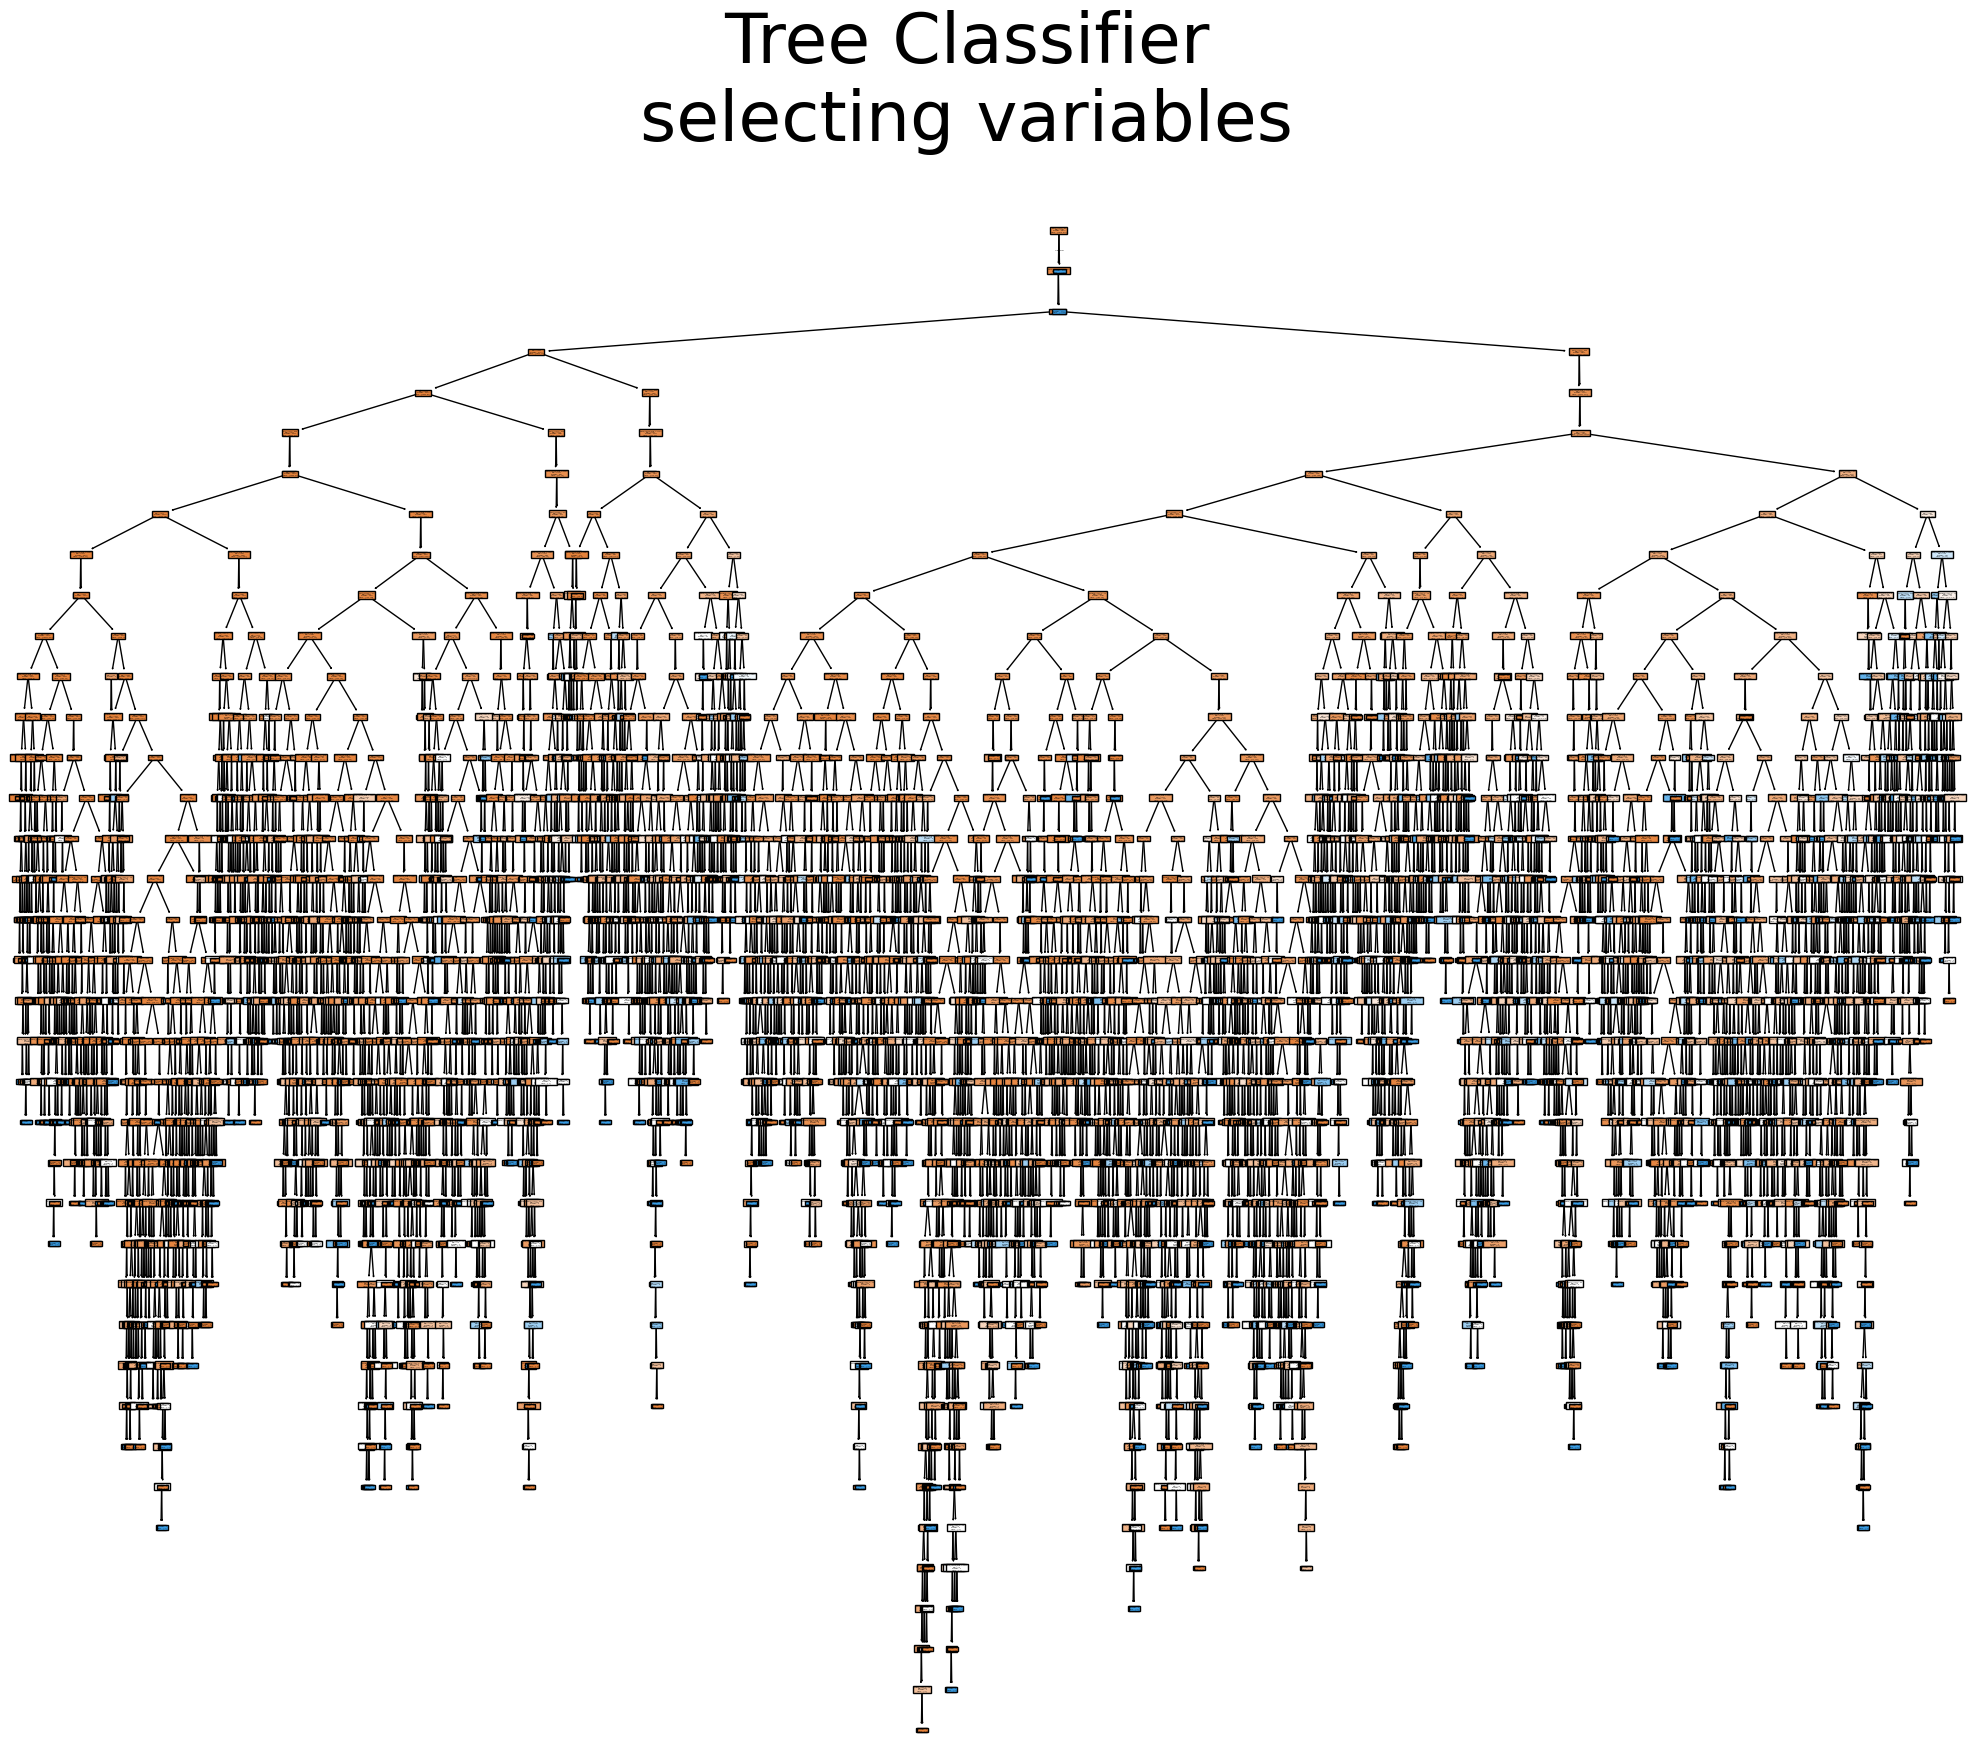

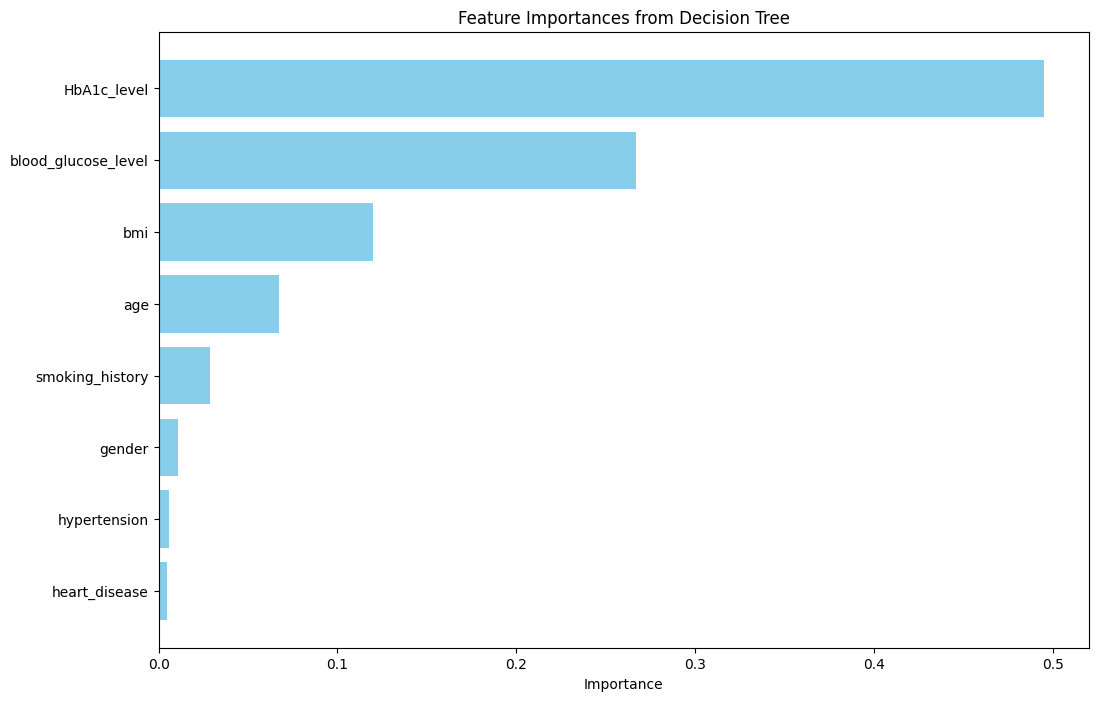

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


s_model = DecisionTreeClassifier(random_state=0) ### voy a dejarlo por defecto

### pipelinde trabajo
y = train_df['diabetes']
X = train_df.iloc[:,:-1]
X.drop(columns=['patient'], inplace=True)

##
types = X.dtypes
cols_cat  = types[types == 'object'].index.to_list()
cols_num  = types[types != 'object'].index.to_list()
X[cols_cat].info() ## solo tengo smoking y gender
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = encoder.fit_transform(X[cols_cat])
new_columns = []
for col, col_values in zip(cols_cat, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))

X = np.hstack([X_cat, X[cols_num].values])
new_columns.extend(cols_num)

X =  pd.DataFrame(data=X, columns=new_columns)


s_model.fit(X,y) ## uso completo por que quiero hacer seleccion de variables

# fig = plt.figure(figsize=(25,20))
# # add title to the plot
# fig.suptitle(' Tree Classifier\n selecting variables', fontsize=50)
# _ = tree.plot_tree(s_model,
#                    feature_names=X.columns,
#                    filled=True)

importances = s_model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

 No hay datos faltantes
- Dos variables categoricas(gender y smoking_history) que fueron transformadas a numéricas, como en el ejemplo del baseline.
- En el caso de gender la categoría other es casi inexistente. Quizas se podría considerar eliminar esos casos, pero para ello es necesario tener más información sobre el dataset y los datos de validación.
- Dataset desbalancedado, muchos más casos de personas sin diabetes, 91,5% vs 8.5% que no presenta la enfermedad.
- Niveles altos de HbA1c_level y blood_glucose_level se ven claramente realacionados a Diabetes. Es importante destacar que en estas variables hay niveles por sobre lo cuales todos los casos son positivos.
- En el caso de la edad, se ve como a partir de los 25 años hay cada vez mayor incidencia de diabetes.
- En lo que respecta al genero, en el dataset hay un mayor presencia de casos femeninos, sin embago en terminos pocentuales, hay más casos de hombres con diabetes.
- De acuerdo al descion tree que armamos, se comprueba lo que observamos en los graficos respecto a la importancia que tienen las variables "HbA1c_level" y "blood_glucose_level".
- Nos llama la atención que bmi tenga una mayor importancia que la edad.
- Respecto a las correlaciones entre variables predictoras, no notamos que existan correlaciones altas, por lo que consideramos mantener todas las variables dentro del analisis.

## Planteo de modelos
Trabajamos con modelos de XGBOOST, RandomForest y MPL.

Para la preparación de los modelos tomamos en cuenta lo siguiente:
- Encoding de las variables categoricas gender y smoking_history, en lugar de usar una categorización ordenada consideramos que sería mejor utilizar onehot encoding
- Tambien exploramos el filtrado de las variables "HbA1c_level" y "blood_glucose_level".
- Se realizaron muchas pruebas con diversos parametros de gridsearch


### XGBOOST - Santiago Costas
#### Ajuste de hiperparámetros utilizando  GridSearchCV con k-folds = 5

Entre muchos testeos posibles que hicimos este es un ejemplo que finaliza con un modelo que mostró muy buena performance tanto en el testeo, como en la competencia de kaggle. Aqui listamos los hiperparámetros con los valores testeados y una breve explicación de cada uno:
- **scale_pos_weight: [0.6,0.8,1,1.2]**   
 Este parámetro ajusta el peso de las clases en la función de pérdida para contrarrestar el desbalance, ayudando al modelo a prestar más atención a la clase minoritaria. Valores mas altos penalizan mas los errores en la clase positiva   
- **learning_rate: [0.01, 0.1, 1]**   
Controla la tasa de aprendizaje del modelo, es decir, cuánto se ajusta el modelo con cada nueva iteración. Valores mas altos son tasas de aprendizaje mas rápidas con riesgo de sobreajuste.
- **max_depth: [3,5,10,None]**.   
Especifica la profundidad máxima de los árboles. Valores mas altos permite árboles más profundos y aumenta la posibilidad de sobreajustar
- **gamma :[0, 0.1, 0.3]**   
Define la reducción mínima en la función de pérdida requerida para realizar una partición adicional en un nodo del árbol. Valores mayores de gamma harán que el modelo sea más conservador, evitando la creación de nuevas particiones en nodos que no ofrezcan una mejora significativa en la función de pérdida   
- **subsample: [0.6, 0.8, 1]**   
Define la proporción de datos de entrenamiento que se utilizan para construir cada árbol. Valores menores de subsample pueden ayudar a prevenir el sobreajuste, ya que introducen aleatoriedad en la construcción de los árboles. Sin embargo, valores muy bajos pueden hacer que el modelo no aprenda correctamente.
- **colsample_bytree: [0.6,0.8,1]**   
Define la proporción de características que se utilizan para construir cada árbol. Efecto similar a subsample.   
- **reg_lambda: [0, 0.1 , 1,10]**   
Controla la regularización L2, que penaliza los coeficientes de las características del modelo. Un valor mayor de reg_lambda incrementa la penalización sobre los pesos de las características.   
- **reg_alpha:[ 0, 0.1, 1, 10]**   
 Controla la regularización L1, que también penaliza los coeficientes de las características, pero puede llevar a que algunos coeficientes sean exactamente cero, lo que implica selección de características.


**El modelo seleccionado fue el siguiente:**
*{'xgbc__colsample_bytree': 1,
 'xgbc__gamma': 0,
 'xgbc__learning_rate': 0.1,
 'xgbc__max_depth': 3,
 'xgbc__n_jobs': -1,
 'xgbc__reg_alpha': 0,
 'xgbc__reg_lambda': 0.1,
 'xgbc__scale_pos_weight': 1.2,
 'xgbc__subsample': 0.8}*

 A continuación la el refit en el entrenamiento, el testo y el entrenamiento completo (totalmente informado) para la prediccion final:


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Estandarización
    ('xgbc', XGBClassifier(random_state = 40, n_jobs = -1))  # voy a usar gradient boost
])
best_params = params = {'xgbc__colsample_bytree': 1,
 'xgbc__gamma': 0,
 'xgbc__learning_rate': 0.1,
 'xgbc__max_depth': 3,
 'xgbc__n_jobs': -1,
 'xgbc__reg_alpha': 0,
 'xgbc__reg_lambda': 0.1,
 'xgbc__scale_pos_weight': 1.2,
 'xgbc__subsample': 0.8}
pipeline.set_params(**best_params) ## seteo los parametros
## entrenamiento
pipeline.fit(X_train, y_train)

## performance y testeo
preds_train = pipeline.predict(X_train)
print(classification_report(y_train, preds_train)) ## para corroborar que no haya sobre ajuste

preds = pipeline.predict(X_test)
print(classification_report(y_train, preds)) ## el modelo tiene un buen rendimiento pero sigue con problemas con el recall de la clase minoritaria

## entrenamiento final para la prediccion para kaggle
pipeline.fit(X, y)

preds_final = pipeline.predict(X) ## solo corroboramos que no haya cambios muy drásticos
print(classification_report(y, preds_final))
##################################################


In [ ]:
################ no correr ###########################
## las siguientes lineas serian para mandar la prediccion final a kaggle
df_test = pd.read_csv('diabetes_prediction_dataset_test.csv')


X = df_test.iloc[:,:-1]

X = X.drop('patient',axis = 1)
### one hoy encoding ################
types = X.dtypes
cols_cat  = types[types == 'object'].index.to_list()
cols_num  = types[types != 'object'].index.to_list()
X[cols_cat].info() ## solo tengo smoking y gender
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_cat = encoder.fit_transform(X[cols_cat])
new_columns = []
for col, col_values in zip(cols_cat, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))

X = np.hstack([X_cat, X[cols_num].values])
new_columns.extend(cols_num)

X =  pd.DataFrame(data=X, columns=new_columns)
#########################################
diabetes_final = pipeline.predict(X) ## cabe destacar que cuando utilizamos el scaler con el pipeline cuando usas predict transofrma los datos con media y desvio del entrenamiento !!!!
df_test['diabetes'] = diabetes_final ## completo los pacientes

entregable = df_test.loc[:,['patient','diabetes']]

pd.DataFrame.to_csv(entregable,'predichos6.csv', index=False)



#### CONCLUSIÓN XGBOOST
En general creemos que es un buen modelo obteniendo en el testeo 97.4 de accuracy y en kaggle 97.285.
Este modelo sigue teniendo problemas con la clase minoritaria (1 = diabetes) ya que si bien la precision es muy alta (aprox 97), es decir lo que clasifica como 1 generlmente es 1 (pocos falsos positivos),  el recall es realativamente bajo 0.67, lo que indica que subestima la cantidad de 1s, la cantidad de falsos negativos es alta. Hay un 30 por ciento de enfermos de diabetes que no está capturando.


### RandomForest - Juan Pablo Baudoin

En el caso de RandomForest probamos con varios modelos de busqueda de hyperparametros con gridsearch. Los parametros que tomamos a consideración para la busqueda con gridsearch tenemos:

- **class_weight**: Define cómo balancear las clases en los datos. Puedes usar 'balanced', donde las clases tendrán un peso inversamente proporcional a su frecuencia, o 'balanced_subsample', que ajusta los pesos en cada árbol. También puedes pasar un diccionario con pesos específicos para cada clase.

- **criterion**: Es el criterio que el modelo usa para medir la calidad de una división. Las opciones comunes son 'gini' (índice de Gini) o 'entropy' (ganancia de información), que determinan cómo se separan los datos en cada nodo del árbol.

- **max_depth**: La profundidad máxima que puede tener cada árbol. Limitar la profundidad ayuda a prevenir el sobreajuste. Si es None, los árboles crecerán hasta que todas las hojas estén puras o tengan menos de min_samples_split muestras.

- **min_samples_leaf**: El número mínimo de muestras que debe tener una hoja (nodo terminal). Si se establece un valor mayor, se evita que el modelo cree nodos con pocas muestras, lo que puede mejorar la generalización.

- **min_samples_split**: El número mínimo de muestras que debe haber en un nodo para que se realice una división. Un valor mayor evita divisiones en nodos con pocas muestras, reduciendo el riesgo de sobreajuste.


- **n_estimators**: El número de árboles en el bosque. Un número mayor generalmente mejora el rendimiento, pero también aumenta el tiempo de entrenamiento


Abajo se tiene el resultado obtenido, para cada busqueda con los parametros de grilla, el mejor modelo obtenido y los resultados de acuracy.
```
Model: RandomForest Case 1
    Grid Params: {'n_estimators': [100],
                  'max_depth': [20], 'min_samples_leaf': (1, 2),
                  'min_samples_split': [2]}
    Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2,
#                      'min_samples_split': 2, 'n_estimators': 100}
    Acuracy train: 0.9774680636098155
    Acuracy test: 0.9702170062001771

Model: RandomForest Case 2
    Grid Params: {'n_estimators': [100, 200, 300, 500], 'max_depth': [7, 10, 20, 30],
                 'min_samples_leaf': [5, 7], 'min_samples_split': [10, 15, 30],
                 'class_weight': ['balanced', 'balanced_subsample'],
                 'criterion': ['gini', 'entropy', 'log_loss']}
    Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy',
                      'max_depth': 30, 'min_samples_leaf': 5,
                      'min_samples_split': 10, 'n_estimators': 500}
    Acuracy train: 0.9548669259407914
    Acuracy test: 0.9316873339238264

Model: RandomForest Case 3
    Grid Params: {'n_estimators': [300, 500], 'max_depth': [5, 7, 10],
                  'min_samples_leaf': [2, 5, 10], 'min_samples_split': [5, 7, 10],
                  'class_weight': ['balanced', 'balanced_subsample'],
                  'criterion': ['gini', 'entropy', 'log_loss']}
    Best Parameters: {'class_weight': 'balanced_subsample', 'criterion': 'gini',
                      'max_depth': 10, 'min_samples_leaf': 2,
                      'min_samples_split': 7, 'n_estimators': 300}
    Acuracy train: 0.830872074515937
    Acuracy test: 0.8236271036315324

```



Es interesante ver que el modelo más simple de busqueda de grilla(RandomForest Case 1) fue el que tuvo un mejor resultado. Llama la atención que la profundidad no es baja y que haya funcionado bien con  min_samples_leaf y min_samples_split ambos con valores bajos, se esperaba mayor sobre ajuste con esos parametros.

### MLPClassifier Miguel Laborde

En el caso de MLPClassifier probamos con los siguientes parametros de gridsearch:
- **alpha**: Es el parámetro de regularización L2 (también conocido como penalización de Ridge). Controla la magnitud de la penalización aplicada a los pesos durante el entrenamiento para prevenir el sobreajuste. Un valor más alto de alpha incrementa la regularización, lo que puede hacer que el modelo sea más simple, pero a costa de precisión.

- **max_iter**: Define el número máximo de iteraciones que se permitirán durante el entrenamiento del modelo. Si el algoritmo no converge antes de llegar a este número de iteraciones, el entrenamiento se detiene. Este parámetro es crucial para evitar que el entrenamiento dure demasiado tiempo.

- **hidden_layer_sizes**: Especifica la cantidad y tamaño de las capas ocultas en la red neuronal. Por ejemplo, (100,) significa una sola capa con 100 neuronas, mientras que (100, 50) significa dos capas ocultas, la primera con 100 neuronas y la segunda con 50. Ajustar este parámetro permite controlar la complejidad de la red.

- **learning_rate**: Controla la tasa de aprendizaje del modelo, que determina cuánto se ajustan los pesos con respecto al error observado en cada iteración. Los valores comunes son 'constant', 'invscaling', y 'adaptive':
 - 'constant': Usa una tasa de aprendizaje fija.
 - 'invscaling': La tasa de aprendizaje disminuye a medida que aumentan las iteraciones.
 - 'adaptive': La tasa de aprendizaje se ajusta según la mejora del rendimiento; si no hay mejora, la tasa se reduce


Abajo se tiene el resultado obtenido con los parametros de grilla, el mejor modelo obtenido y los resultados de acuracy.


```
Model: MPL_model Case 1
    Grid Params: {'alpha': [0.001, 0.01, 0.5, 1, 3.5], 'max_iter': [500, 1000, 5000, 10000], 'hidden_layer_sizes': [(5, 5), (14, 14), (14, 7, 3), (14, 7)], 'learning_rate': ['constant', 'adaptive']}
    Best Parameters: {'alpha': 0.5, 'hidden_layer_sizes': (14, 14), 'learning_rate': 'constant', 'max_iter': 5000}
    Acuracy train: 0.9673369963876932
    Acuracy test: 0.9663972542072631
```




## Conclusion general

Dado que la preparación y ejecución de estos modelos es costosa en tiempo y procesamiento, es muy importante armar procesos de automatización que permitan hacer muchas pruebas y contrastarlas. Esto lo hicimos al final de ejercicio y se puede ver en el archivo model_automation.ipynb
